In [93]:
#required imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression, LogisticRegression
import numpy as np
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score
from sklearn.metrics import accuracy_score as acc, roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold

In [114]:
#loading the diabetes dataset
df = pd.read_csv('pima_indians_diabetes2.csv')
df.head()

,Numbpreg,Plasmaglucose,Diastolicbloodpressure,Triceps,seruminsulin,bodymass,Diabetespedigree,Age,Classvariable
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Classvariable here is the target which classifies a patient as diabetic/not diabetic. This data set includes key variables known to be indicators of type 2 diabetes including, plasma glucose level, body mass index (to determine obesity) but we will also analyse the use of other variables such as whether or not the individual has been pregnant, and if so, how many pregnancies have they had 

In [3]:
#finding the number of missing values for each predictor
preds = ['Plasmaglucose','Diastolicbloodpressure','Triceps','seruminsulin','bodymass','Age']
for pred in preds:
    count = len(df[df[pred]==0.0])
    print('0 values for',pred,':',count)

0 values for Plasmaglucose : 5
0 values for Diastolicbloodpressure : 35
0 values for Triceps : 227
0 values for seruminsulin : 374
0 values for bodymass : 11
0 values for Age : 0


For the above predictors we are considering the 0 values in each predictor as missing values, for example bodymass of a person cannot be 0, similarly other indicators cannot be 0 as well.

We would be replacing these 0 values by using Linear regression. The predictor with which we would do this would be Age as there are no 0 values for this predictor

In [115]:
#imputing missing value using regression from the column age
#using the predictor values we have to calculate regression coefficients
preds = ['Plasmaglucose','Diastolicbloodpressure','Triceps','seruminsulin','bodymass']
count=0
for diabetes_pred in preds: 
    #use 0 or df[~df['Age'].isnull()]
    df1 = df[df[diabetes_pred]!=0.0]
    #reshaping the predictor as a 2D array to use in regression
    if count==0:
        x = np.array(df1['Age']).reshape((-1, 1))
    else:
        x = np.array(df1[preds[count-1]]).reshape((-1, 1))
    y = df1[diabetes_pred]
    #training the model on the training_data
    diabetes_lm = LinearRegression()
    #training data, target value
    diabetes_lm.fit(x, y)
    #regression intercept and coefficient
    intercept = diabetes_lm.intercept_
    b1 = diabetes_lm.coef_[0]
    #use 0 or df[df['column name'].isnull()]
    df2 = df[df[diabetes_pred]==0.0]
     #generating the predicted values to replace the 0 values for predictors
    if count ==0:
        Age = list(df2['Age'])
        new_pred = [intercept + b1*a for a in Age]
    else:
        pred = list(df2[preds[count-1]])
        new_pred = [intercept + b1*a for a in pred]
    #replacing the 0 values
    dict_df2 = dict(df2)
    i=0
    for key,glucose_value in dict_df2[diabetes_pred].items():
        dict_df2[diabetes_pred][key] = new_pred[i]
        i=i+1
    df3 = pd.DataFrame(data = dict_df2)
    count = count + 1
    #sorting the dataframe to have the records with 0 values at the end of the dataframe
    #these rows will be replaced by the rows in df3 where missing values have been imputed
    df4 = df.sort_values(by=[diabetes_pred],ascending=False)
    index_names = df4[df4[diabetes_pred]==0].index
    df5= df4.drop(index_names)
    #merging the two dataframes
    df = pd.concat([df5,df3])
df

<ipython-input-115-bd4a29853add>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dict_df2[diabetes_pred][key] = new_pred[i]
C:\Users\harsh\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-115-bd4a29853add>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dict_df2[diabetes_pred][key] = new_pred[i]
C:\Users\

,Numbpreg,Plasmaglucose,Diastolicbloodpressure,Triceps,seruminsulin,bodymass,Diabetespedigree,Age,Classvariable
177,0,129,110,46,130,67.100000,0.319,26,1
445,0,180,78,63,14,59.400000,2.420,25,1
673,3,123,100,35,240,57.300000,0.880,22,0
125,1,88,30,42,99,55.000000,0.496,26,1
120,0,162,76,56,100,53.200000,0.759,25,1
...,...,...,...,...,...,...,...,...,...
49,7,105,70,28,153,32.416211,0.305,24,0
426,0,94,69,28,153,32.416211,0.256,25,0
60,2,84,68,28,153,32.416211,0.304,21,0
494,3,80,68,28,153,32.416211,0.174,22,0


In [116]:
df.to_excel('pima_diabetes_v1.xlsx')

After replacing the imputed values, the next step was to add some derived variables to our dataset.
These variables are created from our source variables in the original dataset to better understand how a predictor affects diabetes.

For instance, the variable obesity is calculated using the variable bodymass. The logic behind it is as follows:

if bodymass>30, then a person will be classified as obese else not obese. According to the National Heart, Lung, and Blood Institute a person with a bmi >30 is obese. Obseity is one of factors linked with the risk of developing diabetes.

Similarly the logic for other variables has been researched and calculated in excel.

In [117]:
diabetes_df = pd.read_excel('pima_diabetes.xlsx')
diabetes_df.head()

,Numbpreg,Plasmaglucose,Diastolicbloodpressure,Triceps,seruminsulin,bodymass,Diabetespedigree,Age,Classvariable,obesity,...,normal_serum_insulin,GDM,GDMIndicator,hyperglycemia,estimated_HbA1c,diabetes_indicator,pregnant_binary,no_preg_before_40,age_vs_glucose_index,high_risk
0,0,129,110,46,130,67.1,0.319,26,1,1,...,1,0.00,0.000,0,6.121951,0,0,0,4.961538,0
1,0,180,78,63,14,59.4,2.420,25,1,1,...,0,0.00,0.000,1,7.898955,1,0,0,7.200000,0
2,3,123,100,35,240,57.3,0.880,22,0,1,...,0,0.27,0.135,0,5.912892,0,1,0,5.590909,0
3,1,88,30,42,99,55.0,0.496,26,1,1,...,1,0.09,0.045,0,4.693380,0,1,0,3.384615,0
4,0,162,76,56,100,53.2,0.759,25,1,1,...,1,0.00,0.000,1,7.271777,1,0,0,6.480000,0


<AxesSubplot:>

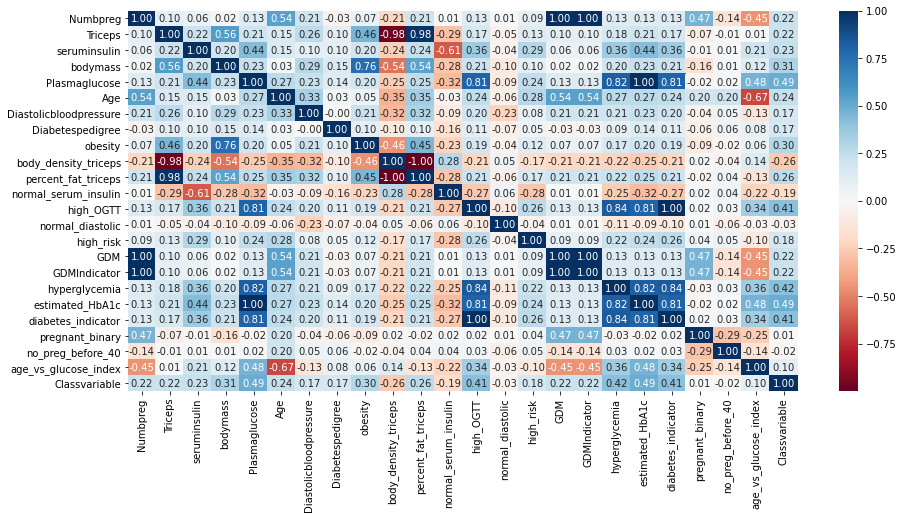

In [118]:
#generating the correlation matrix
source_df = diabetes_df.loc[:,['Numbpreg','Triceps','seruminsulin','bodymass','Plasmaglucose','Age','Diastolicbloodpressure','Diabetespedigree','obesity','body_density_triceps','percent_fat_triceps','normal_serum_insulin','high_OGTT','normal_diastolic','high_risk','GDM','GDMIndicator','hyperglycemia','estimated_HbA1c','diabetes_indicator','pregnant_binary','no_preg_before_40','age_vs_glucose_index',
                       'Classvariable']]
#correlation matrix
corr = source_df.corr()
#creating a heatmap for the correlation matrix
fig, ax = plt.subplots()
fig.set_size_inches(15, 7)
#annot=True displays data in the boxes
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu', center=0,
ax=ax)

In [119]:
#calculate correlation and significance- to check the the strength of linear relationship b/w predictor and target(classvariable in this case)
predictors = ['Numbpreg','Triceps','seruminsulin','bodymass','Plasmaglucose','Age','Diastolicbloodpressure','Diabetespedigree','obesity','body_density_triceps','percent_fat_triceps','normal_serum_insulin','high_OGTT',
             'normal_diastolic','high_risk','GDM','GDMIndicator','hyperglycemia','estimated_HbA1c',
             'diabetes_indicator','pregnant_binary','no_preg_before_40','age_vs_glucose_index']
for predictor in predictors:
    data1 = diabetes_df[predictor]
    data2 = diabetes_df['Classvariable']
    print(predictor,':',stats.pearsonr(data1, data2))

Numbpreg : (0.2218981530339868, 5.065127298051538e-10)
Triceps : (0.2235727409735908, 3.7232201074376324e-10)
seruminsulin : (0.22780893765961863, 1.6904921162494994e-10)
bodymass : (0.31214632885626364, 8.099093515651529e-19)
Plasmaglucose : (0.49410014252285195, 1.615431723466383e-48)
Age : (0.23835598302719777, 2.209975460664566e-11)
Diastolicbloodpressure : (0.17222860816186059, 1.5780816860827854e-06)
Diabetespedigree : (0.17384406565296012, 1.254607010148255e-06)
obesity : (0.2966089098848803, 4.613907403108056e-17)
body_density_triceps : (-0.26401319475711577, 1.030147698320449e-13)
percent_fat_triceps : (0.2631152338624586, 1.2558523125043542e-13)
normal_serum_insulin : (-0.1946753899769731, 5.378278640439967e-08)
high_OGTT : (0.41445528077201577, 3.0952745084854466e-33)
normal_diastolic : (-0.03151671956675124, 0.38309328549209565)
high_risk : (0.17548998922561937, 9.909691580791087e-07)
GDM : (0.2218981530339868, 5.065127298051538e-10)
GDMIndicator : (0.2218981530339868, 5.06

Based on the above generated correlation coefficient and the their p-values, we generate a report on which variables are the most correlated and whether that correlation is significant or not. We will consider these variables for our final model but the final variables will also be calculted based on their partial r squared values.

array([[<AxesSubplot:title={'center':'Numbpreg'}>,
        <AxesSubplot:title={'center':'Plasmaglucose'}>,
        <AxesSubplot:title={'center':'Diastolicbloodpressure'}>,
        <AxesSubplot:title={'center':'Triceps'}>,
        <AxesSubplot:title={'center':'seruminsulin'}>],
       [<AxesSubplot:title={'center':'bodymass'}>,
        <AxesSubplot:title={'center':'Diabetespedigree'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Classvariable'}>,
        <AxesSubplot:title={'center':'obesity'}>],
       [<AxesSubplot:title={'center':'body_density_triceps'}>,
        <AxesSubplot:title={'center':'percent_fat_triceps'}>,
        <AxesSubplot:title={'center':'normal_diastolic'}>,
        <AxesSubplot:title={'center':'high_OGTT'}>,
        <AxesSubplot:title={'center':'normal_serum_insulin'}>],
       [<AxesSubplot:title={'center':'GDM'}>,
        <AxesSubplot:title={'center':'GDMIndicator'}>,
        <AxesSubplot:title={'center':'hyperglycemia'}>,
  

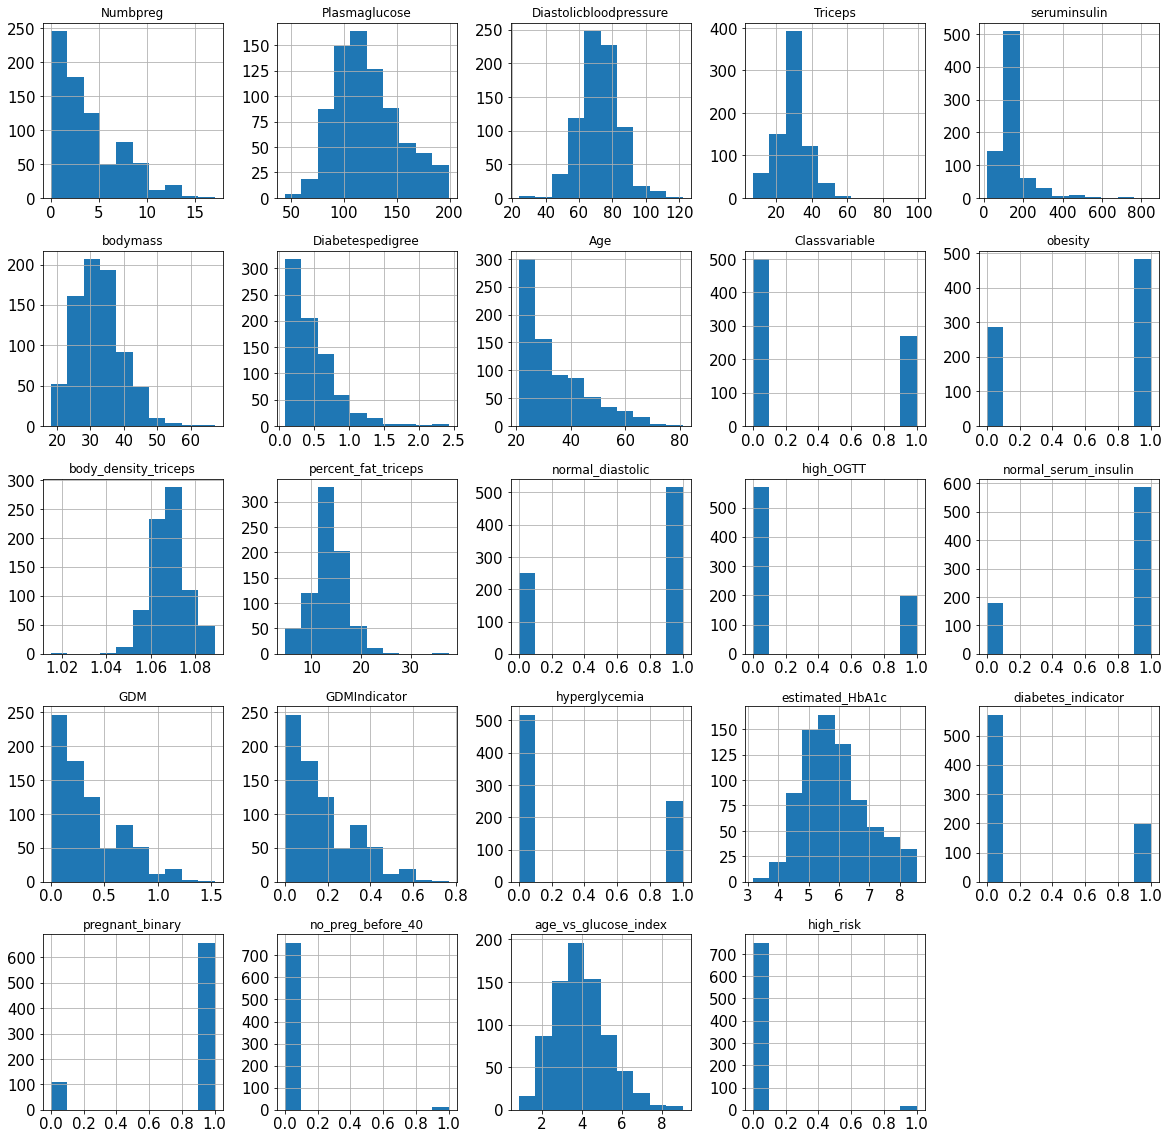

In [120]:
#histograms to see data distributions
diabetes_df.hist(bins=10, figsize=(20,20), xlabelsize= 15, ylabelsize = 15)

First we'll run logistic regression using all the predictors

In [151]:
#setting the target -> y and predictor -> x variables
y = diabetes_df['Classvariable']
X = diabetes_df.drop(columns=['Classvariable'])
#60-40 split b/w training and validation data.
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)
# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42,solver='liblinear')
logit_reg.fit(train_X, train_y) 
print('intercept ', logit_reg.intercept_[0]) # the value of Y when all X=0. value of beta-0

intercept  -1.6735407923542238


In [152]:
#coefficients of the predictors
print(pd.DataFrame({'coeff': logit_reg.coef_[0]},
index=X.columns).transpose())

       Numbpreg  Plasmaglucose  Diastolicbloodpressure   Triceps  \
coeff  0.053229       0.168744                0.000005 -0.415001   

       seruminsulin  bodymass  Diabetespedigree       Age   obesity  \
coeff      0.000745    0.0408          1.584029 -0.131623  0.602913   

       body_density_triceps  ...  normal_serum_insulin       GDM  \
coeff             -1.845697  ...              0.396744  0.004791   

       GDMIndicator  hyperglycemia  estimated_HbA1c  diabetes_indicator  \
coeff      0.002395       0.204926        -2.717269           -0.333602   

       pregnant_binary  no_preg_before_40  age_vs_glucose_index  high_risk  
coeff        -0.584422           1.428422             -0.919167   0.585187  

[1 rows x 23 columns]


In [153]:
#mean accuracy of model on training data
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(logit_reg, train_X, train_y, cv=cv)
print("Accuracy: %.3f%% (%.3f%%)" % (scores.mean()*100.0, scores.std()*100.0))

Accuracy: 77.029% (3.045%)


In [154]:
#mean accuracy of model on validation data
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(logit_reg, valid_X, valid_y, cv=cv)
print("Accuracy: %.3f%% (%.3f%%)" % (scores.mean()*100.0, scores.std()*100.0))

Accuracy: 75.761% (4.536%)


In [155]:
logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_proba = logit_reg.predict_proba(valid_X)
logit_result = pd.DataFrame({'actual': valid_y,
'probability_0': [p[0] for p in
logit_reg_proba],
'probability_1': [p[1] for p in
logit_reg_proba],
'predicted': logit_reg_pred })
logit_result

,actual,probability_0,probability_1,predicted
285,1,0.271382,0.728618,1
101,1,0.022738,0.977262,1
581,0,0.118279,0.881721,1
352,0,0.921452,0.078548,0
726,0,0.981390,0.018610,0
...,...,...,...,...
486,0,0.979755,0.020245,0
600,0,0.893559,0.106441,0
38,1,0.240390,0.759610,1
659,0,0.980243,0.019757,0


In [156]:
#roc curve with actual value and predicted probability of class 1
fpr, tpr, threshold = roc_curve(logit_result.actual, logit_result.probability_1)
roc_auc = auc(fpr, tpr)

In [157]:
#optimum threshold value - record classified as 1 if probability of being in category 1 > threshold value
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]
optimal_threshold

0.2957337525808178

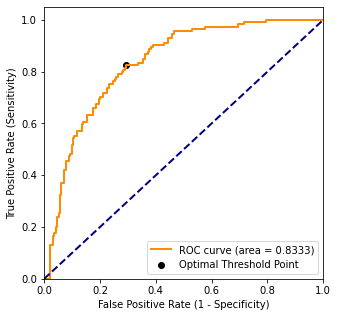

In [158]:
plt.figure(figsize=[5, 5])
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#plotting the sensitivity and false postive rate w.r.t the optimal threshold
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label='Optimal Threshold Point') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")

plt.show()

In [159]:
#false positive rate corresponding to the optimal threshold point
fpr[optimal_idx]

0.29381443298969073

In [160]:
#true positive rate corresponding to the optimal threshold point
tpr[optimal_idx]

0.8245614035087719

The final predictors were calculated using stepwise regression where the variables were cosnidered on the basis of their % contribution in predicting the target variable. This was done by running proc stepwise in sas.

The contribution was measured using their partial r squared values. The code for that below:

*run stepwise on final model variables in order to create final model report; 
libname log_reg "/home/u54322937/my_shared_file_links/u54322937/diabetes";

PROC IMPORT DATAFILE="/home/u54322937/my_shared_file_links/u54322937/diabetes/pima_diabetes.xlsx" 
			OUT=log_reg.pima_diabetes_v1 DBMS=XLSX REPLACE;
		GETNAMES=YES;
	RUN;
	




proc stepwise data=log_reg.pima_diabetes_v1;

model classvariable=
	bodymass
	plasmaglucose
	age
	diastolicbloodpressure
	diabetespedigree
	obesity
	body_density_triceps
	percent_fat_triceps
	normal_serum_insulin
	high_OGTT
	normal_diastolic
	high_risk
	GDM
	GDMIndicator
	hyperglycemia
	estimated_HbA1c
	diabetes_indicator
	pregnant_binary
	no_preg_before_40
	age_vs_glucose_index 
 /sls=.05 sle=.05;

run;

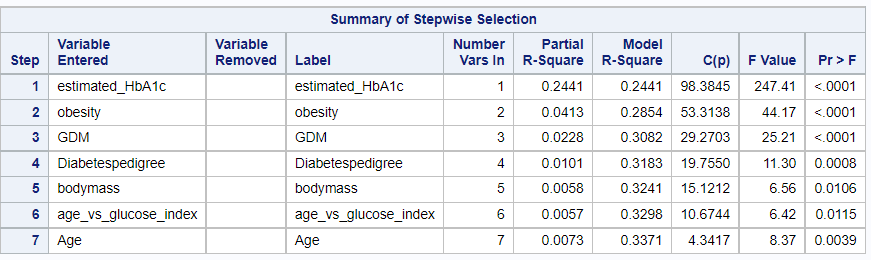

The results that would be seen by running the above proc might vary due to some predictors being highly correlated. Since they would have the same impact on the target, the model can use one or the other.

The % contribution of a predictor can be calculated by dividing the partial R squared value of a predictor by the final model R squared value

In [161]:
#running logistic regression on final model variables
#setting the target -> y and predictor -> x variables
y = diabetes_df['Classvariable']
X = diabetes_df.loc[:,['estimated_HbA1c','bodymass','GDM','Diabetespedigree',
                       'age_vs_glucose_index','Age','obesity']]
#60-40 split b/w training and validation data. 60-40 split b/w the outcome varible data as well
# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)
# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42,solver='liblinear')
logit_reg.fit(train_X, train_y) 
print('intercept ', logit_reg.intercept_[0]) # the value of Y when all X=0. value of beta-0

intercept  -9.574544432814415


In [162]:
#coefficients of the predictors
print(pd.DataFrame({'coeff': logit_reg.coef_[0]},
index=X.columns).transpose())

       estimated_HbA1c  bodymass       GDM  Diabetespedigree  \
coeff         1.867738  0.052793  0.236225           1.42493   

       age_vs_glucose_index       Age   obesity  
coeff             -0.873578 -0.048744  0.606136  


In [163]:
#mean accuracy of model on training data
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(logit_reg, train_X, train_y, cv=cv)
print("Accuracy: %.3f%% (%.3f%%)" % (scores.mean()*100.0, scores.std()*100.0))

Accuracy: 77.319% (3.122%)


In [164]:
#mean accuracy of model on validation data
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(logit_reg, valid_X, valid_y, cv=cv)
print("Accuracy: %.3f%% (%.3f%%)" % (scores.mean()*100.0, scores.std()*100.0))

Accuracy: 76.631% (4.548%)


In [165]:
logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_proba = logit_reg.predict_proba(valid_X)
logit_result = pd.DataFrame({'actual': valid_y,
'probability_0': [p[0] for p in
logit_reg_proba],
'probability_1': [p[1] for p in
logit_reg_proba],
'predicted': logit_reg_pred })
logit_result

,actual,probability_0,probability_1,predicted
285,1,0.323087,0.676913,1
101,1,0.028086,0.971914,1
581,0,0.214448,0.785552,1
352,0,0.911871,0.088129,0
726,0,0.975133,0.024867,0
...,...,...,...,...
486,0,0.973459,0.026541,0
600,0,0.925362,0.074638,0
38,1,0.230888,0.769112,1
659,0,0.977070,0.022930,0


In [166]:
#roc curve with actual value and predicted probability of class 1
fpr, tpr, threshold = roc_curve(logit_result.actual, logit_result.probability_1)
roc_auc = auc(fpr, tpr)

In [167]:
#optimum threshold value - record classified as 1 if probability of being in category 1 > threshold value
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]
optimal_threshold

0.28157913326286504

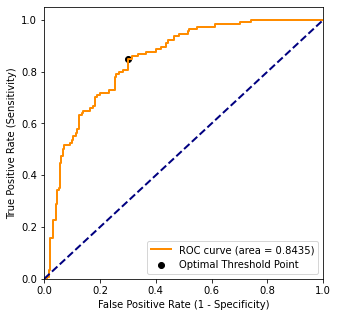

In [168]:
#plotting the roc curve
plt.figure(figsize=[5, 5])
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#plotting the sensitivity and false postive rate w.r.t the optimal threshold
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label='Optimal Threshold Point') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")

plt.show()

In [169]:
#false positive rate corresponding to the optimal threshold point
fpr[optimal_idx]

0.29896907216494845

In [170]:
#true positive rate corresponding to the optimal threshold point
tpr[optimal_idx]

0.8508771929824561